In [34]:
import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from tqdm import tqdm
import json

# Paths
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
TRAIN_SPLIT = os.path.join(BASE_PATH, 'train_split.json')
VAL_SPLIT = os.path.join(BASE_PATH, 'val_split.json')
CLASS_WEIGHTS_PATH = os.path.join(BASE_PATH, 'class_weights.json')
SAVED_MODEL_DIR = "C:/Users/User/Desktop/saved_model"
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

# Constants
NUM_CLASSES = 4  # Soil, Bedrock, Sand, Big Rock
BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3
L2_REGULARIZATION = 1e-4

# Load class weights
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights = json.load(f)["class_weights"]  # Extract the list of weights
class_weights = torch.tensor(class_weights, dtype=torch.float32)  # Convert to PyTorch tensor


class RealMarsDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list of dict): List of dictionaries with keys 'image' and 'mask'
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read image and mask paths
        image_path = self.data[idx]['image']
        mask_path = self.data[idx]['mask']

        # Load preprocessed image and mask
        image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32) / 255.0  # Normalize to [0, 1]
        image = cv2.resize(image, (256, 256))  # Resize to 256x256
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # Convert HWC to CHW and ensure float

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.int64)  # Ensure mask is int64 (long)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Replace 255 with -1 (ignore index)
        mask[mask == 255] = -1

        # One-hot encoding for masks
        mask_one_hot = torch.zeros((NUM_CLASSES, mask.shape[0], mask.shape[1]), dtype=torch.float32)
        for c in range(NUM_CLASSES):
            mask_one_hot[c] = torch.tensor(mask == c, dtype=torch.float32)  # Convert NumPy to PyTorch tensor

        return image, torch.tensor(mask, dtype=torch.long), mask_one_hot

# Load splits
def load_splits(split_path):
    with open(split_path, 'r') as f:
        return json.load(f)

train_split = load_splits(TRAIN_SPLIT)
val_split = load_splits(VAL_SPLIT)

# DataLoaders
train_dataset = RealMarsDataset(train_split)
val_dataset = RealMarsDataset(val_split)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# MobileNetV2 Model with Dropout
class MobileNetV2Segmentation(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(MobileNetV2Segmentation, self).__init__()
        backbone = models.mobilenet_v2(pretrained=True)
        self.encoder = backbone.features
        self.decoder = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Hybrid Loss
def hybrid_loss(pred, target, target_one_hot, ignore_index=-1):
    valid_target = target.clone()
    valid_target[valid_target == ignore_index] = 0

    wce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)(pred, valid_target)

    pred_softmax = torch.softmax(pred, dim=1)

    dice_loss = 1 - (2 * (pred_softmax * target_one_hot).sum(dim=(2, 3)) /
                     ((pred_softmax + target_one_hot).sum(dim=(2, 3)) + 1e-6)).mean()

    tversky_loss = 1 - ((pred_softmax * target_one_hot).sum(dim=(2, 3)) /
                        ((pred_softmax * target_one_hot).sum(dim=(2, 3)) +
                         0.7 * (pred_softmax * (1 - target_one_hot)).sum(dim=(2, 3)) +
                         0.3 * ((1 - pred_softmax) * target_one_hot).sum(dim=(2, 3)) + 1e-6)).mean()

    focal_loss = -(target_one_hot * ((1 - pred_softmax) ** 2) * torch.log(pred_softmax + 1e-6)).mean()

    return wce_loss + dice_loss + tversky_loss + focal_loss

# Training Loop
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, save_path, early_stopping_patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_val_loss = float('inf')
    early_stopping_counter = 0

    def mean_iou(pred, target, num_classes):
        """Calculate Mean IoU."""
        pred = torch.argmax(pred, dim=1)
        ious = []
        for cls in range(num_classes):
            intersection = ((pred == cls) & (target == cls)).sum().item()
            union = ((pred == cls) | (target == cls)).sum().item()
            if union > 0:
                ious.append(intersection / union)
        return np.mean(ious) if ious else 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_correct, train_total, train_iou = 0, 0, 0, 0.0

        for images, masks, masks_one_hot in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            images, masks, masks_one_hot = images.to(device), masks.to(device), masks_one_hot.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = hybrid_loss(outputs, masks, masks_one_hot)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Accuracy
            preds = outputs.argmax(dim=1)
            train_correct += (preds == masks).sum().item()
            train_total += masks.numel()

            # Mean IoU
            train_iou += mean_iou(outputs, masks, NUM_CLASSES)

        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total
        train_mean_iou = train_iou / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total, val_iou = 0, 0, 0, 0.0
        with torch.no_grad():
            for images, masks, masks_one_hot in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                images, masks, masks_one_hot = images.to(device), masks.to(device), masks_one_hot.to(device)
                outputs = model(images)
                loss = hybrid_loss(outputs, masks, masks_one_hot)
                val_loss += loss.item()

                # Accuracy
                preds = outputs.argmax(dim=1)
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()

                # Mean IoU
                val_iou += mean_iou(outputs, masks, NUM_CLASSES)

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_mean_iou = val_iou / len(val_loader)

        # Scheduler step
        scheduler.step(val_loss)

        # Print Epoch Summary
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train IoU: {train_mean_iou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val IoU: {val_mean_iou:.4f}, "
              f"Time: {epoch_time:.2f}s")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

# Initialize Model and Train
model = MobileNetV2Segmentation(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REGULARIZATION)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=EPOCHS,
    save_path=os.path.join(SAVED_MODEL_DIR, 'MobileNetV2.pth'),
    early_stopping_patience=5
)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/15 - Val

Epoch 1/15 - Train Loss: 2.6851, Train Accuracy: 0.2788, Train IoU: 0.1341, Val Loss: 2.3757, Val Accuracy: 0.3408, Val IoU: 0.2495, Time: 1743.88s
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 2/15 - Validation: 100%|██████████| 302/302 [02:29<00:00,  2.01it/s]


Epoch 2/15 - Train Loss: 2.2048, Train Accuracy: 0.4567, Train IoU: 0.3650, Val Loss: 1.9805, Val Accuracy: 0.4841, Val IoU: 0.4006, Time: 1665.45s
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 3/15 - Validation: 100%|██████████| 302/302 [02:37<00:00,  1.91it/s]


Epoch 3/15 - Train Loss: 1.9794, Train Accuracy: 0.4854, Train IoU: 0.4045, Val Loss: 1.9236, Val Accuracy: 0.5034, Val IoU: 0.4409, Time: 1740.34s
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 4/15 - Validation: 100%|██████████| 302/302 [02:16<00:00,  2.21it/s]


Epoch 4/15 - Train Loss: 1.9125, Train Accuracy: 0.4948, Train IoU: 0.4176, Val Loss: 1.9032, Val Accuracy: 0.4993, Val IoU: 0.4254, Time: 1702.75s
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 5/15 - Validation: 100%|██████████| 302/302 [02:17<00:00,  2.20it/s]


Epoch 5/15 - Train Loss: 1.8698, Train Accuracy: 0.5009, Train IoU: 0.4330, Val Loss: 1.9282, Val Accuracy: 0.5178, Val IoU: 0.4550, Time: 1595.40s


Epoch 6/15 - Validation: 100%|██████████| 302/302 [02:18<00:00,  2.17it/s]


Epoch 6/15 - Train Loss: 1.8281, Train Accuracy: 0.5057, Train IoU: 0.4436, Val Loss: 1.8635, Val Accuracy: 0.5047, Val IoU: 0.4506, Time: 1611.06s
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 7/15 - Validation: 100%|██████████| 302/302 [02:19<00:00,  2.16it/s]


Epoch 7/15 - Train Loss: 1.8095, Train Accuracy: 0.5087, Train IoU: 0.4513, Val Loss: 1.8653, Val Accuracy: 0.5016, Val IoU: 0.4378, Time: 1613.89s


Epoch 8/15 - Validation: 100%|██████████| 302/302 [02:19<00:00,  2.16it/s]


Epoch 8/15 - Train Loss: 1.7815, Train Accuracy: 0.5134, Train IoU: 0.4587, Val Loss: 1.8704, Val Accuracy: 0.5156, Val IoU: 0.4574, Time: 1612.60s


Epoch 9/15 - Validation: 100%|██████████| 302/302 [02:20<00:00,  2.15it/s]


Epoch 9/15 - Train Loss: 1.7666, Train Accuracy: 0.5152, Train IoU: 0.4659, Val Loss: 1.8760, Val Accuracy: 0.5042, Val IoU: 0.4505, Time: 1613.87s


Epoch 10/15 - Validation: 100%|██████████| 302/302 [02:19<00:00,  2.17it/s]


Epoch 10/15 - Train Loss: 1.7442, Train Accuracy: 0.5187, Train IoU: 0.4775, Val Loss: 1.8922, Val Accuracy: 0.5057, Val IoU: 0.4732, Time: 1630.47s


Epoch 11/15 - Validation: 100%|██████████| 302/302 [02:18<00:00,  2.18it/s]

Epoch 11/15 - Train Loss: 1.6943, Train Accuracy: 0.5260, Train IoU: 0.5006, Val Loss: 1.8667, Val Accuracy: 0.5168, Val IoU: 0.4831, Time: 1614.66s
Early stopping triggered. No improvement in validation loss.


Evaluating Model: 100%|██████████| 302/302 [02:05<00:00,  2.41it/s]


Classification Report:
              precision    recall  f1-score   support

        Soil     0.8461    0.9836    0.9097  32495798
     Bedrock     0.9878    0.8598    0.9194  43578871
        Sand     0.9163    0.9036    0.9099  10873451
    Big Rock     0.4843    0.8160    0.6079    761427

    accuracy                         0.9107  87709547
   macro avg     0.8087    0.8907    0.8367  87709547
weighted avg     0.9221    0.9107    0.9119  87709547



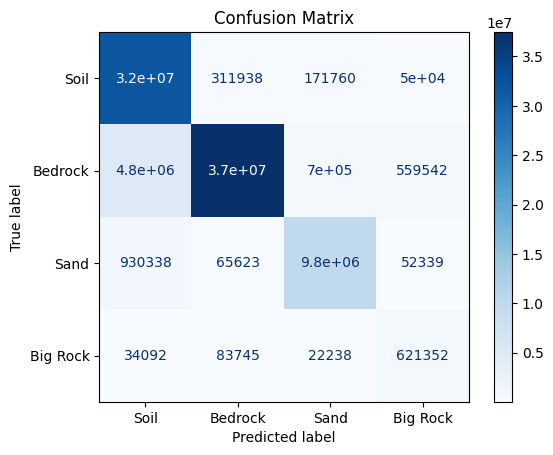

TypeError: 'function' object is not subscriptable

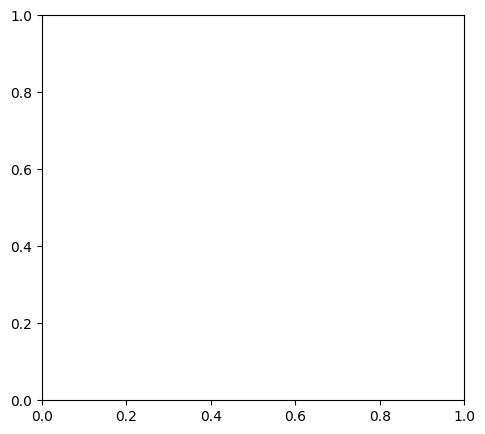

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Paths
TEST_SPLIT = os.path.join(BASE_PATH, 'test_split.json')
MODEL_PATH = os.path.join(SAVED_MODEL_DIR, 'MobileNetV2.pth')

# Load test dataset
test_split = load_splits(TEST_SPLIT)
test_dataset = RealMarsDataset(test_split)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Load trained model
model = MobileNetV2Segmentation(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate Model
all_preds = []
all_targets = []
with torch.no_grad():
    for images, masks, _ in tqdm(test_loader, desc="Evaluating Model"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy().flatten()
        targets = masks.cpu().numpy().flatten()

        all_preds.extend(preds)
        all_targets.extend(targets)

# Remove the ignored class (-1) for evaluation
valid_indices = [i for i in range(len(all_targets)) if all_targets[i] != -1]
all_preds = [all_preds[i] for i in valid_indices]
all_targets = [all_targets[i] for i in valid_indices]

# Classification Report
target_names = ["Soil", "Bedrock", "Sand", "Big Rock"]
report = classification_report(all_targets, all_preds, target_names=target_names, digits=4)
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Learning Curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label="Train Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label="Train Accuracy")
    plt.plot(history['val_accuracy'], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` dictionary is returned from the training function
plot_learning_curves(train_model)


# MobileNetV2 2

Epoch 1/15 [Val]: 100%|██████████| 151/151 [01:52<00:00,  1.35it/s]


[Epoch 1/15] Train Loss: 2.6557, Train Acc: 0.7513, Val Loss: 2.4526, Val Acc: 0.7959, LR: 0.001000
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 2/15 [Val]: 100%|██████████| 151/151 [01:47<00:00,  1.40it/s]


[Epoch 2/15] Train Loss: 2.2952, Train Acc: 0.8277, Val Loss: 2.1315, Val Acc: 0.8643, LR: 0.001000
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth
Learning Rate decayed to 0.000700 at epoch 2


Epoch 3/15 [Val]: 100%|██████████| 151/151 [02:43<00:00,  1.08s/it]


[Epoch 3/15] Train Loss: 2.1091, Train Acc: 0.8439, Val Loss: 2.0006, Val Acc: 0.8775, LR: 0.000700
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 4/15 [Val]: 100%|██████████| 151/151 [02:43<00:00,  1.08s/it]


[Epoch 4/15] Train Loss: 2.0582, Train Acc: 0.8556, Val Loss: 1.9316, Val Acc: 0.8933, LR: 0.000700
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth
Learning Rate decayed to 0.000490 at epoch 4


Epoch 5/15 [Val]: 100%|██████████| 151/151 [02:55<00:00,  1.16s/it]


[Epoch 5/15] Train Loss: 1.9520, Train Acc: 0.8833, Val Loss: 1.9351, Val Acc: 0.8945, LR: 0.000490


Epoch 6/15 [Val]: 100%|██████████| 151/151 [02:42<00:00,  1.08s/it]


[Epoch 6/15] Train Loss: 1.9160, Train Acc: 0.8934, Val Loss: 1.9008, Val Acc: 0.9039, LR: 0.000490
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth
Learning Rate decayed to 0.000343 at epoch 6


Epoch 7/15 [Val]: 100%|██████████| 151/151 [02:43<00:00,  1.08s/it]


[Epoch 7/15] Train Loss: 1.8580, Train Acc: 0.9102, Val Loss: 1.8603, Val Acc: 0.9197, LR: 0.000343
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 8/15 [Val]: 100%|██████████| 151/151 [02:43<00:00,  1.09s/it]


[Epoch 8/15] Train Loss: 1.8360, Train Acc: 0.9139, Val Loss: 1.8599, Val Acc: 0.9087, LR: 0.000343
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth
Learning Rate decayed to 0.000240 at epoch 8


Epoch 9/15 [Val]: 100%|██████████| 151/151 [02:44<00:00,  1.09s/it]


[Epoch 9/15] Train Loss: 1.7926, Train Acc: 0.9252, Val Loss: 1.8505, Val Acc: 0.9221, LR: 0.000240
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth


Epoch 10/15 [Val]: 100%|██████████| 151/151 [02:42<00:00,  1.08s/it]


[Epoch 10/15] Train Loss: 1.7815, Train Acc: 0.9275, Val Loss: 1.8425, Val Acc: 0.9226, LR: 0.000240
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth
Learning Rate decayed to 0.000168 at epoch 10


Epoch 11/15 [Val]: 100%|██████████| 151/151 [02:44<00:00,  1.09s/it]


[Epoch 11/15] Train Loss: 1.7502, Train Acc: 0.9352, Val Loss: 1.8458, Val Acc: 0.9131, LR: 0.000168


Epoch 12/15 [Val]: 100%|██████████| 151/151 [02:44<00:00,  1.09s/it]


[Epoch 12/15] Train Loss: 1.7390, Train Acc: 0.9368, Val Loss: 1.8253, Val Acc: 0.9197, LR: 0.000168
Model saved to C:/Users/User/Desktop/saved_model\MobileNetV2.pth
Learning Rate decayed to 0.000118 at epoch 12


Epoch 13/15 [Val]: 100%|██████████| 151/151 [02:44<00:00,  1.09s/it]


[Epoch 13/15] Train Loss: 1.7167, Train Acc: 0.9427, Val Loss: 1.8398, Val Acc: 0.9126, LR: 0.000118


Epoch 14/15 [Val]: 100%|██████████| 151/151 [02:43<00:00,  1.09s/it]


[Epoch 14/15] Train Loss: 1.7071, Train Acc: 0.9453, Val Loss: 1.8484, Val Acc: 0.9261, LR: 0.000118
Learning Rate decayed to 0.000082 at epoch 14


Epoch 15/15 [Val]: 100%|██████████| 151/151 [02:44<00:00,  1.09s/it]


[Epoch 15/15] Train Loss: 1.6969, Train Acc: 0.9468, Val Loss: 1.8632, Val Acc: 0.9356, LR: 0.000082


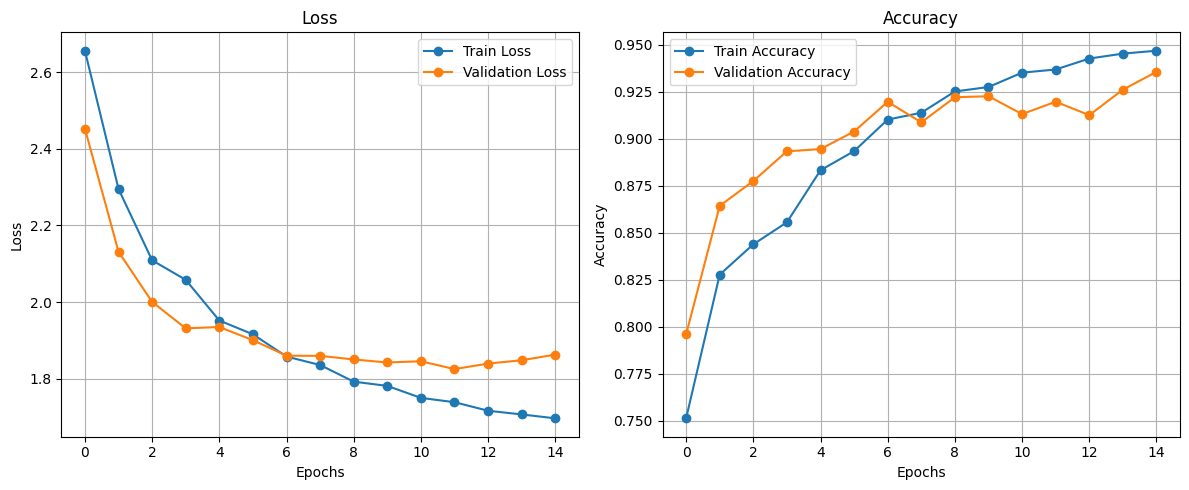

Training complete. Results have been saved.


In [4]:
import os
import time
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ------------------- CONFIG -------------------
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
TRAIN_SPLIT = os.path.join(BASE_PATH, 'train_split.json')
VAL_SPLIT   = os.path.join(BASE_PATH, 'val_split.json')
CLASS_WEIGHTS_PATH = os.path.join(BASE_PATH, 'class_weights.json')
SAVED_MODEL_DIR    = "C:/Users/User/Desktop/saved_model"
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

NUM_CLASSES        = 4   # Soil, Bedrock, Sand, Big Rock
BATCH_SIZE         = 16
EPOCHS             = 15
LEARNING_RATE      = 1e-3
L2_REGULARIZATION  = 1e-4
DROPOUT_RATE       = 0.3
MIN_DELTA          = 1e-5
PATIENCE           = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ---------------------------------------------

# ----------------- DATA LOADING -------------
def load_splits(split_path):
    with open(split_path, 'r') as f:
        return json.load(f)

train_split = load_splits(TRAIN_SPLIT)
val_split   = load_splits(VAL_SPLIT)

# Load class weights
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_json = json.load(f)
class_weights = torch.tensor(class_weights_json["class_weights"], dtype=torch.float32)

class RealMarsDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list[dict]): List of dictionaries with 'image' and 'mask' keys
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read image and mask paths
        image_path = self.data[idx]['image']
        mask_path  = self.data[idx]['mask']

        # Load and preprocess image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            image = np.zeros((256, 256, 3), dtype=np.float32)
        else:
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, (256, 256))
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # (C,H,W)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
        else:
            mask = mask.astype(np.int64)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Replace 255 with -1 for ignore index
        mask[mask == 255] = -1

        # Create one-hot encoding (not strictly needed if using cross-entropy with ignore_index)
        mask_one_hot = torch.zeros((NUM_CLASSES, mask.shape[0], mask.shape[1]), dtype=torch.float32)
        for c in range(NUM_CLASSES):
            mask_class = (mask == c).astype(np.float32)
            mask_one_hot[c] = torch.from_numpy(mask_class)

        return image, torch.tensor(mask, dtype=torch.long), mask_one_hot

train_dataset = RealMarsDataset(train_split)
val_dataset   = RealMarsDataset(val_split)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
# ---------------------------------------------

# ------------------ MODEL DEF ----------------
class MobileNetV2Segmentation(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(MobileNetV2Segmentation, self).__init__()
        backbone = models.mobilenet_v2(pretrained=True)
        self.encoder = backbone.features
        
        self.decoder = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# ---------------------------------------------

# ---------------- LOSS FUNCTIONS ------------
def hybrid_loss(pred, target, target_one_hot, ignore_index=-1):
    # Weighted Cross-Entropy
    valid_target = target.clone()
    valid_target[valid_target == ignore_index] = 0  # Map ignore to class 0 for WCE
    wce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)(pred, valid_target)

    # Softmax for dice / tversky / focal
    pred_softmax = torch.softmax(pred, dim=1)

    # Dice loss
    dice_loss = 1 - (2 * (pred_softmax * target_one_hot).sum(dim=(2, 3)) /
                     ((pred_softmax + target_one_hot).sum(dim=(2, 3)) + 1e-6)).mean()

    # Tversky loss
    alpha, beta = 0.7, 0.3
    true_pos = (pred_softmax * target_one_hot).sum(dim=(2, 3))
    false_neg = (target_one_hot * (1 - pred_softmax)).sum(dim=(2, 3))
    false_pos = ((1 - target_one_hot) * pred_softmax).sum(dim=(2, 3))
    tversky_index = true_pos / (true_pos + alpha * false_neg + beta * false_pos + 1e-6)
    tversky_loss = 1 - tversky_index.mean()

    # Focal loss
    focal_loss = -(target_one_hot * ((1 - pred_softmax) ** 2) * torch.log(pred_softmax + 1e-6)).mean()

    return wce_loss + dice_loss + tversky_loss + focal_loss
# ---------------------------------------------

# ---------------- TRAIN FUNCTION ------------
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, save_path, early_stopping_patience=5):
    model.to(DEVICE)
    best_val_loss = float('inf')
    early_stopping_counter = 0

    # We'll store training history in these lists so that
    # we don't get the "'function' object is not subscriptable" error.
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    def mean_iou(pred, target, num_classes):
        """Calculate Mean IoU."""
        pred = torch.argmax(pred, dim=1)
        ious = []
        for cls in range(num_classes):
            intersection = ((pred == cls) & (target == cls)).sum().item()
            union = ((pred == cls) | (target == cls)).sum().item()
            if union > 0:
                ious.append(intersection / union)
        return np.mean(ious) if ious else 0.0

    curr_lr = optimizer.param_groups[0]['lr']  # Keep track of current LR

    for epoch in range(num_epochs):
        # Manually adjust LR every 2 epochs by factor=0.7
        if epoch > 0 and epoch % 2 == 0:
            curr_lr = curr_lr * 0.7
            for param_group in optimizer.param_groups:
                param_group['lr'] = curr_lr
            print(f"Learning Rate decayed to {curr_lr:.6f} at epoch {epoch}")

        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, masks, masks_one_hot in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = hybrid_loss(outputs, masks, masks_one_hot)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Accuracy calculation
            preds = outputs.argmax(dim=1)
            valid_indices = (masks != -1)  # ignore index
            train_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
            train_total   += valid_indices.sum().item()

        # Compute training metrics
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0.0

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, masks, masks_one_hot in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)
                outputs = model(images)
                loss = hybrid_loss(outputs, masks, masks_one_hot)
                val_loss += loss.item()

                # Accuracy calculation
                preds = outputs.argmax(dim=1)
                valid_indices = (masks != -1)
                val_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
                val_total   += valid_indices.sum().item()

        val_loss      /= len(val_loader)
        val_accuracy  = val_correct / val_total if val_total > 0 else 0.0

        # Step the ReduceLROnPlateau with the validation loss
        scheduler.step(val_loss)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, LR: {curr_lr:.6f}")

        # Save metrics to history
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

    return history

# ---------------- PLOT LEARNING CURVES --------------
def plot_learning_curves(history):
    """Plot training and validation loss, accuracy using the stored `history` dict."""
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label="Train Loss", marker='o')
    plt.plot(history['val_loss'], label="Validation Loss", marker='o')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label="Train Accuracy", marker='o')
    plt.plot(history['val_accuracy'], label="Validation Accuracy", marker='o')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# ---------------- MAIN SCRIPT ----------------
if __name__ == "__main__":
    model = MobileNetV2Segmentation(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REGULARIZATION)

    # Setup ReduceLROnPlateau
    reduce_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-10, verbose=1)

    # Train
    history = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        reduce_on_plateau,    # we pass our scheduler
        num_epochs=EPOCHS,
        save_path=os.path.join(SAVED_MODEL_DIR, 'MobileNetV2.pth'),
        early_stopping_patience=PATIENCE
    )

    # Plot the final learning curves
    plot_learning_curves(history)

    print("Training complete. Results have been saved.")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classification Report:
              precision    recall  f1-score   support

        Soil     0.8772    0.9800    0.9257  32495798
     Bedrock     0.9869    0.8809    0.9309  43578871
        Sand     0.9204    0.9235    0.9219  10873451
    Big Rock     0.3841    0.8028    0.5196    761427

    accuracy                         0.9222  87709547
   macro avg     0.7921    0.8968    0.8245  87709547
weighted avg     0.9327    0.9222    0.9243  87709547



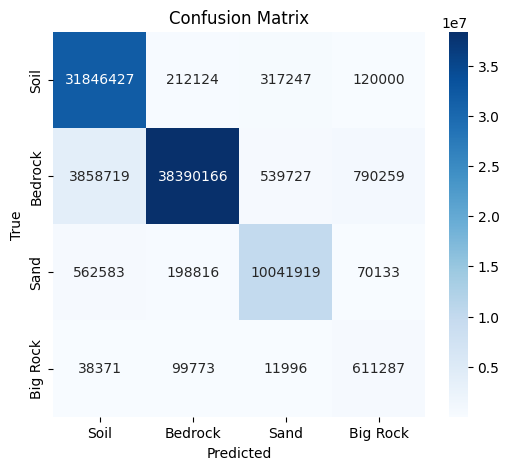

Per-Class IoU:
  Soil: 0.8618
  Bedrock: 0.8707
  Sand: 0.8552
  Big Rock: 0.3509
Mean IoU: 0.7347


In [7]:
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your test split and define a DataLoader similar to how you do it for train/val
#    (Assuming you have test_split.json or something similar).
test_split_path = os.path.join(BASE_PATH, "test_split.json")

# Example RealMarsDataset usage for the test set (reusing the same class from your code)
test_split_data = load_splits(test_split_path)
test_dataset = RealMarsDataset(test_split_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 2. Load the trained model and set it to eval mode
model = MobileNetV2Segmentation(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE)
model_path = os.path.join(SAVED_MODEL_DIR, 'MobileNetV2.pth')
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# 3. Inference on the test set and gather predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks, _ in test_loader:  # We don't necessarily need masks_one_hot for evaluation
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(dim=1)  # shape: (batch_size, H, W)

        # Move to CPU
        preds_np  = preds.cpu().numpy()
        masks_np  = masks.cpu().numpy()

        # Flatten them, but exclude the -1 ignore pixels
        for i in range(preds_np.shape[0]):
            valid_indices = (masks_np[i] != -1)  # mask is -1 => ignore
            valid_preds   = preds_np[i][valid_indices]
            valid_targets = masks_np[i][valid_indices]
            all_preds.extend(valid_preds.tolist())
            all_targets.extend(valid_targets.tolist())

# 4. Classification report (multi-class)
#    We specify the class indices and their names for interpretability:
class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]
report = classification_report(
    all_targets,
    all_preds,
    labels=[0, 1, 2, 3],
    target_names=class_names,
    digits=4
)
print("Classification Report:")
print(report)

# 5. Confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Compute class-wise and mean IoU
#    We can adapt the mean_iou approach to aggregated data here
def compute_iou(preds, targets, num_classes):
    """
    preds: list or 1D array of predicted class indices
    targets: list or 1D array of ground truth class indices
    Returns: array of IoU values for each class, plus mean IoU
    """
    ious = []
    for cls in range(num_classes):
        intersection = 0
        union = 0
        for p, t in zip(preds, targets):
            intersection += int(p == cls and t == cls)
            union        += int((p == cls) or (t == cls))
        if union == 0:
            ious.append(float('nan'))  # or 0 if you prefer
        else:
            ious.append(intersection / union)
    return ious

ious = compute_iou(all_preds, all_targets, NUM_CLASSES)
print("Per-Class IoU:")
for idx, iou_val in enumerate(ious):
    print(f"  {class_names[idx]}: {iou_val:.4f}")
mean_iou = np.nanmean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

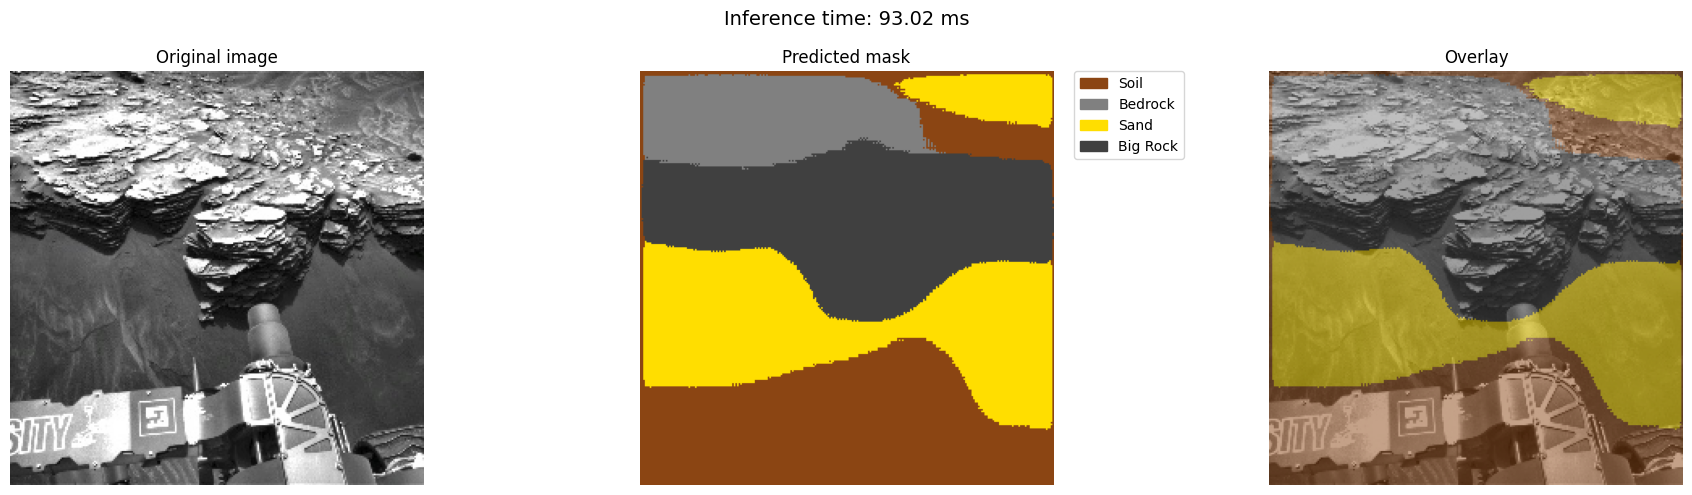

In [22]:
import os
import json
import time
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming your MobileNetV2Segmentation class and other definitions are already available:
# from your_code import MobileNetV2Segmentation, RealMarsDataset, ...

BASE_PATH       = "C:/Users/User/Desktop/ai4mars/msl"
TEST_SPLIT      = os.path.join(BASE_PATH, "test_split.json")
SAVED_MODEL_DIR = "C:/Users/User/Desktop/saved_model"
MODEL_PATH      = os.path.join(SAVED_MODEL_DIR, "MobileNetV2.pth")

NUM_CLASSES     = 4
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class names
class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]

# Color map for each class in BGR (as used by OpenCV)
color_map = {
    0: (19, 69, 139),   # Soil
    1: (128, 128, 128), # Bedrock
    2: (0, 222, 255), # Sand
    3: (64, 64, 64), # Big Rock
}

def load_test_split(test_split_path):
    with open(test_split_path, 'r') as f:
        return json.load(f)

def load_preprocess_single_image(img_path):
    """Load the image from disk, resize to 256x256, normalize to [0..1], 
       then convert to PyTorch tensor (C,H,W)."""
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        # If image is missing, create a dummy black image
        image = np.zeros((256, 256, 3), dtype=np.float32)
    else:
        image = image.astype(np.float32) / 255.0
        image = cv2.resize(image, (256, 256))
    # Convert from HWC to CHW
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float()
    return image_tensor

def visualize_prediction(original_bgr, predicted_mask, inference_ms):
    """Visualize original image, predicted mask (with legend), and overlay."""
    # Convert BGR to RGB for plotting
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # Build a color-coded segmentation image
    seg_vis = np.zeros((256, 256, 3), dtype=np.uint8)
    for cls_idx, bgr in color_map.items():
        seg_vis[predicted_mask == cls_idx] = bgr

    # Convert for display in matplotlib (BGR -> RGB)
    seg_vis_rgb = cv2.cvtColor(seg_vis, cv2.COLOR_BGR2RGB)

    # Create overlay
    overlay = cv2.addWeighted(original_bgr, 0.5, seg_vis, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(18, 5))

    # 1. Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_rgb)
    plt.title("Original image")
    plt.axis('off')

    # 2. Predicted Mask with Legend
    plt.subplot(1, 3, 2)
    plt.imshow(seg_vis_rgb)
    plt.title("Predicted mask")
    plt.axis('off')

    # Build legend patches
    patches = []
    for i, name in enumerate(class_names):
        b, g, r = color_map[i]  # BGR
        color_rgb = (r/255, g/255, b/255)
        patch = mpatches.Patch(color=color_rgb, label=name)
        patches.append(patch)

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # 3. Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay_rgb)
    plt.title("Overlay")
    plt.axis('off')

    plt.suptitle(f"Inference time: {inference_ms:.2f} ms", fontsize=14)
    plt.tight_layout()
    plt.show()

def main():
    # 1. Load test split
    test_data = load_test_split(TEST_SPLIT)
    if not test_data:
        raise ValueError("Test split is empty or missing.")

    # 2. Select an image from the test split
    # -----------IMAGE ID---------------------
    image_id = 732
    # ----------------------------------------
    if image_id < 0 or image_id >= len(test_data):
        raise ValueError(f"Invalid image_id: {image_id}, must be between 0 and {len(test_data)-1}.")
    sample = test_data[image_id]
    image_path = sample["image"]

    # 3. Load the trained model
    model = MobileNetV2Segmentation(num_classes=NUM_CLASSES, dropout_rate=0.3)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # 4. Preprocess the single image
    image_tensor = load_preprocess_single_image(image_path).unsqueeze(0).to(DEVICE)

    # For display, load the original image in BGR
    original_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_bgr is None:
        original_bgr = np.zeros((256,256,3), dtype=np.uint8)
    else:
        original_bgr = cv2.resize(original_bgr, (256, 256))

    # 5. Inference and measure time
    start_time = time.time()
    with torch.no_grad():
        output = model(image_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000

    # 6. Convert to predicted mask
    pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()

    # 7. Visualization
    visualize_prediction(original_bgr, pred_mask, inference_time_ms)

if __name__ == "__main__":
    main()
